In [1]:
import numpy as np
import csv
# Needed for plotting
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt

# Needed for generating data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
import seaborn as sns

#plt.rcParams["figure.figsize"] = (12, 12)

In [2]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')

In [3]:
def point_of_intersection(pair_of_lines):
    l = np.array(pair_of_lines)
    point = np.cross(l[0], l[1])
    point = point / point[2]
    return point

def line_from_pair_of_points(pair_of_points):
    p = np.array(pair_of_points)
    line = np.cross(p[0], p[1])
    return line

def line_from_point_and_direction(point, direction):
    return line_from_pair_of_points((point, direction))
 
def matrix_from_weights(weights, bias):
    W = np.hstack((weights, bias[:, np.newaxis]))
    W = np.vstack((W, np.array([0,0,1])))
    return W
    
def aff_inv(aff_matrix):
    A = aff_matrix[[0,1], :][:, [0,1]]
    b = aff_matrix[:, 2][[0, 1]]
    det = A[1,1]*A[0,0] - A[0,1]*A[1,0]
    A = np.array([ [ A[1,1], -A[0,1] ],
                   [-A[1,0],  A[0,0] ]])
    b = - A.dot(b)
    return matrix_from_weights(A/det, b/det)

def affine_map_old(three_points_0, three_points_1, aff_inverse=False):
    p_0 = np.array(three_points_0)
    p_1 = np.array(three_points_1)
    if aff_inverse:
        p_0[[0,1]] = p_0[[0,1]] - p_0[2]
        p_1[[0,1]] = p_1[[0,1]] - p_1[2]
        p_0 = p_0.T
        p_1 = p_1.T
        return p_1.dot(aff_inv(p_0))
    else:
        A = np.linalg.inv(p_0).dot(p_1).T
        A[-1] = np.array([0.,0.,1])
        return A
    
def affine_map(three_points_0, three_points_1):
    p_0 = np.array(three_points_0)
    p_1 = np.array(three_points_1)
    # p_1 = p_0.dot(A.T)
    # inv(p_0).dot(p_1) = A.T
    # A.T = inv(p_0).dot(p_1)
    A = np.linalg.inv(p_0).dot(p_1)
    A = A.T
    A[2] = np.array([0.,0.,1])
    return A
    
def organize_input(weights, bias, final_layer=True):
    n = len(weights)-1
    W = []
    for i in range(n):
        W.append(matrix_from_weights(weights[i], bias[i]))
    if final_layer:
        W.append(np.array([ weights[n][0],  weights[n][1],  bias[n][0]]))
    return W

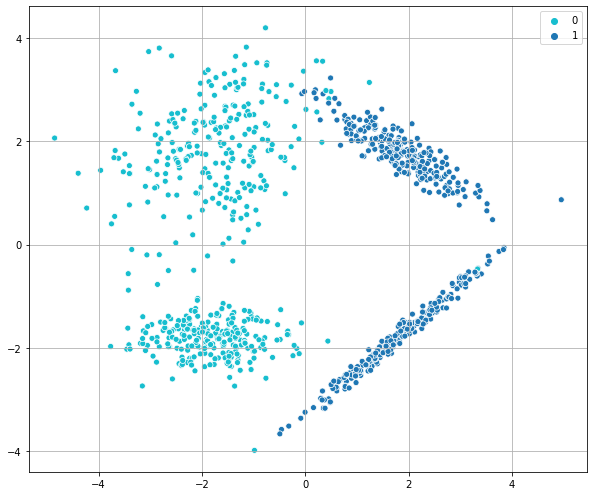

In [4]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(10,10))
plt_ind_list = np.arange(3)+131
ax.set_aspect('equal')

for class_sep,plt_ind in zip([1],plt_ind_list):
    x2,y2 = dt.make_classification(n_samples=1000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=1.8,
                                 n_redundant=0,
                                 random_state=rand_state)
    palette = {0:"tab:cyan",
               1:"tab:blue", 
               }
    sns.scatterplot(x2[:,0], x2[:,1], hue = y2, palette=palette )

ax.grid()
plt.show()



Q = [ 0.5 -1.9  1. ]


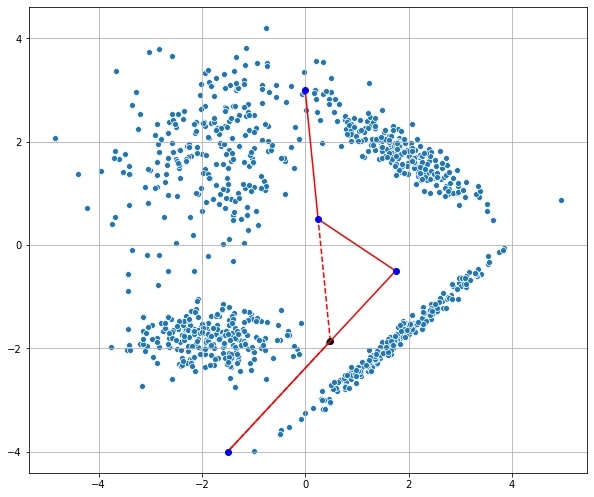

In [5]:
# NEW VERSION

# Data Layer:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.set_aspect('equal')


colors = { 0: "tab:cyan",  1: "tab:blue" }
sns.scatterplot(x2[:,0], x2[:,1], palette=colors  )

PL0 = np.array([ [ -1.5,   -4.,  1.],
                [ 1.75,  -0.5,  1.],
                [ 0.25,   0.5,  1.],
                [    0.,    3,  1.]])

PL = PL0

L1 = line_from_pair_of_points(PL[[0,1]])
L2 = line_from_pair_of_points(PL[[2,3]])
Q = point_of_intersection((L1, L2))

print('Q =', Q.round(1))

ax.plot([Q[0], PL[2,0]], [Q[1], PL[2,1]], 'r--')
ax.plot([Q[0], PL[0,0]], [Q[1], PL[0,1]], 'r--')
ax.plot([Q[0]], [Q[1]], 'ko')

ax.plot(PL[:,0], PL[:,1], 'r')
for p in PL:
    ax.plot(p[0], p[1], 'bo')


plt.grid()
plt.show()



=====
[[ 0.47955803  0.91933705 -0.37955803]
 [-0.33055467  0.30694363  1.73194249]
 [ 0.          0.          1.        ]]



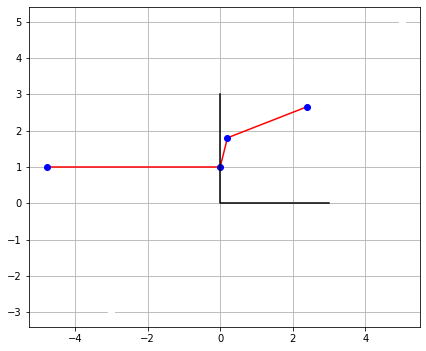

[-1.11022302e-16  1.00000000e+00  1.00000000e+00]
[0.2        1.80277564 1.        ]
[2.37845312 2.65277337 1.        ]


In [6]:

# Layer 1:

a = 0.2
source = np.array([PL[1], PL[2], Q])
image = np.array([ [0., 1.,1.],  
                   [ a, np.linalg.norm(PL[1]-PL[2]), 1.],
                   [-np.linalg.norm(Q - PL[1]), 1.,  1.] ])


M1 = affine_map(source, image)
print("=====")
print(M1)
print('')


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.set_aspect('equal')

PL1 = PL.dot(M1.T)
L1 = line_from_pair_of_points(PL1[[0,1]])
L2 = line_from_pair_of_points(PL1[[2,3]])
Q = point_of_intersection((L1, L2))

# for p in PL:
#     print(p)
# print('')

#print('Q =', Q)

#ax.plot([Q[0], PL[2,0]], [Q[1], PL[2,1]], 'r--')
#ax.plot([Q[0], PL[0,0]], [Q[1], PL[0,1]], 'r--')
#ax.plot([Q[0]], [Q[1]], 'ko')
ax.plot([-3, 5], [-3, 5], 'wo')

ax.plot(PL1[:,0], PL1[:,1], 'r')
for p in PL1:
    ax.plot(p[0], p[1], 'bo')

end = 3
B = np.array([[end, 0, 1],[0, 0, 1],[0, end, 1]]).T

ax.plot(B[0], B[1], 'k')

plt.grid()
plt.show()

print(PL1[1])
print(PL1[2])
print(PL1[3])

[2.17845312 0.84999773 0.        ]
[-0.2        -0.80277564  0.        ]
[[ 0.93159649  0.36349412  0.        ]
 [-0.2        -0.80277564  0.        ]
 [ 0.2         1.80277564  1.        ]]
[[ 1.1890081  -0.29622426  0.49622426]
 [ 0.65062921  1.08358315 -2.08358315]
 [ 0.          0.          1.        ]]



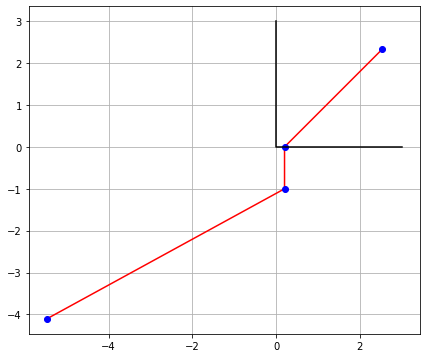

In [17]:

# Layer 2:

# create the vector between points PL[2] and PL[3] and then make length 1
u = PL1[3]-PL1[2]
print(u)
u = u / np.linalg.norm(u)
# get the unit vector v perpendicular  to the unit vector u, so that v points downwards
v = PL1[1]-PL1[2]
print(v)
#you get an orthonormal basisi PL[2], u, v in layer 1
source = np.array([u, v, PL1[2]]) 
print(source)
# you want to map it by a rotation and translation congruent transfromation 
# to the basis in layer 2 formed by PL{1]=[0,1,1], [-1, 0, 0], [0, 1, 0]
image  = np.array([[1, 1., 0.], [0, -1., 0.], [0.2,0,1]])

M2 = affine_map(source, image)
print('==============')
print(M2)
print('')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.set_aspect('equal')


#colors = { 0: "tab:cyan",  1: "tab:blue" }
#sns.scatterplot(x1[:,0], x1[:,1], palette=colors  )

PL2 = PL1.dot(M2.T)


ax.plot(PL2[:,0], PL2[:,1], 'r')
for p in PL2:
    ax.plot(p[0], p[1], 'bo')

ax.plot(B[0], B[1], 'k')
    
plt.grid()
plt.show()


=====
[-1.  -1.5  1. ]


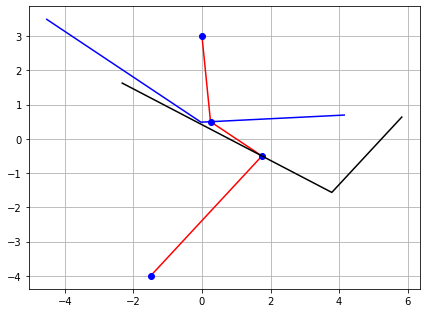

In [21]:


# Layer 3:

# line between PL[1] and Pl[2]

M3 = line_from_pair_of_points(PL[[1, 2]])
print("=====")
print(M3)

# sectors in data layer:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))
ax.set_aspect('equal')


#colors = { 0: "tab:cyan",  1: "tab:blue" }
#sns.scatterplot(x1[:,0], x1[:,1], palette=colors  )


PL = PL0

ax.plot(PL[:,0], PL[:,1], 'r')
for p in PL:
    ax.plot(p[0], p[1], 'bo')

B1 = np.linalg.inv(M1).dot(B)
B2 = np.linalg.inv(M2.dot(M1)).dot(B)

ax.plot(B1[0], B1[1], 'k')
ax.plot(B2[0], B2[1], 'b')

plt.grid()
plt.show()

In [22]:

M = [M1, M2, M3]



for m in M:
    print('')
    print(m)
print('')


[[ 0.47955803  0.91933705 -0.37955803]
 [-0.33055467  0.30694363  1.73194249]
 [ 0.          0.          1.        ]]

[[ 1.1890081  -0.29622426  0.49622426]
 [ 0.65062921  1.08358315 -2.08358315]
 [ 0.          0.          1.        ]]

[-1.  -1.5  1. ]



In [26]:
M21 = M2.dot(M1)
M31 = M3.dot(M21)
print(M31)

[-0.59886319 -2.39829478  2.14886319]


In [23]:
M

[array([[ 0.47955803,  0.91933705, -0.37955803],
        [-0.33055467,  0.30694363,  1.73194249],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[ 1.1890081 , -0.29622426,  0.49622426],
        [ 0.65062921,  1.08358315, -2.08358315],
        [ 0.        ,  0.        ,  1.        ]]),
 array([-1. , -1.5,  1. ])]

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
plt_ind_list = np.arange(3)+131

for class_sep,plt_ind in zip([1],plt_ind_list):
    x2,y2 = dt.make_classification(
    n_samples=1000, 
    n_features=2, 
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.95],
    flip_y=0.01, #add noise
    class_sep =1.2,
    random_state=42
)
    palette = {0:"tab:cyan",
               1:"tab:blue", 
               }
    sns.scatterplot(x2[:,0],x2[:,1], hue = y2, palette=palette )

plt.show()